In [1]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import gzip, cPickle
from tqdm import tqdm 

from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa as tsa 
from statsmodels.tsa.stattools import coint

from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from statsmodels.tsa.stattools import adfuller as ADF
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from itertools import combinations
from tqdm import tqdm
import pickle
from datetime import datetime as dt
import math

C:\Users\Juntao\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## This step is to download and load all the ETF data

In [3]:
# pickle.dump(ETFs_GSPC, open("ETFs_GSPC_MRP_Production.p", "w"))
with gzip.open('ETFs_GSPC_MRP_Production.pkl.gz','r') as f:
    ETFs_GSPC = cPickle.load(f)

In [4]:
All_ETFs = ETFs_GSPC.iloc[:, :-1]

In [4]:
All_ETFs.head(5)

,XLK,VGT,IYW,RYT,IGM,XNTK,PNQI,XLF,VFH,KBE,...,XLU,VPU,IDU,RYU,PUI,VNQ,IYR,RWR,REM,USRT
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,22.098740,53.268589,56.017902,45.235744,54.408684,27.862883,NaN,14.305944,41.652599,35.166389,...,28.566296,59.947933,71.388649,41.737343,14.337612,40.162682,42.196808,47.435150,8.983622,34.976913
2008-01-03,22.132580,52.997772,55.789246,44.755886,54.259819,27.940943,NaN,14.215148,41.288517,35.025986,...,28.525572,60.058559,71.592514,41.917027,14.271438,38.910671,40.830173,46.044064,8.910232,33.672215
2008-01-04,21.269606,50.750046,53.393055,42.910275,51.757092,26.646067,NaN,13.811594,40.147667,33.836712,...,28.742760,59.899540,71.543304,41.633671,14.278792,37.330921,39.534801,44.102032,8.794044,32.376438
2008-01-07,21.083485,50.280647,52.890045,42.310459,51.347736,26.297098,NaN,13.846903,40.333759,34.150543,...,29.340000,60.985104,72.815964,42.158928,14.558186,37.678326,39.903980,44.398148,8.888833,32.447933
2008-01-08,20.525089,48.737019,51.298668,41.396889,49.868423,25.723120,NaN,13.342463,38.836933,32.705246,...,29.346796,60.950520,72.717522,42.158928,14.455253,36.373859,38.453159,42.951958,8.757350,31.482798


In [7]:
GSPC = pd.DataFrame(ETFs_GSPC.iloc[:, -1])

In [13]:
GSPC.loc["2008-01": "2017-12-31"].shape

(2518, 1)

In [8]:
GSPC.head(5)

,Adj Close
Date,
2008-01-02,1447.160034
2008-01-03,1447.160034
2008-01-04,1411.630005
2008-01-07,1416.180054
2008-01-08,1390.189941


In [7]:
All_ETFs_log = All_ETFs.apply(np.log)
All_ETFs_log.head()

,XLK,VGT,IYW,RYT,IGM,XNTK,PNQI,XLF,VFH,KBE,...,XLU,VPU,IDU,RYU,PUI,VNQ,IYR,RWR,REM,USRT
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,3.095521,3.975347,4.025671,3.811888,3.996524,3.327295,NaN,2.660675,3.729364,3.560091,...,3.352228,4.093476,4.268139,3.731396,2.662886,3.692938,3.742345,3.859364,2.195403,3.554688
2008-01-03,3.097051,3.970250,4.021581,3.801223,3.993784,3.330093,NaN,2.654308,3.720584,3.556090,...,3.350801,4.095320,4.270991,3.735692,2.658260,3.661269,3.709421,3.829599,2.187200,3.516673
2008-01-04,3.057279,3.926913,3.977681,3.759111,3.946561,3.282642,NaN,2.625508,3.692564,3.521546,...,3.358386,4.092669,4.270303,3.728909,2.658775,3.619822,3.677181,3.786506,2.174075,3.477431
2008-01-07,3.048490,3.917620,3.968215,3.745034,3.938621,3.269459,NaN,2.628062,3.697189,3.530778,...,3.378952,4.110630,4.287935,3.741446,2.678153,3.629085,3.686476,3.793198,2.184796,3.479637
2008-01-08,3.021648,3.886439,3.937665,3.723206,3.909388,3.247390,NaN,2.590952,3.659372,3.487535,...,3.379183,4.110062,4.286582,3.741446,2.671058,3.593850,3.649441,3.760082,2.169893,3.449441


In [8]:
All_ETFs_log.drop(['RYF','FTXO','PNQI', 'JHMC','PSCH','PSCI','PSCC','PSCM','XTL','REM','RYF','XLF'], axis=1, inplace=True) # 51Z ETFs left

In [6]:
All_ETFs_log.head()

NameError: name 'All_ETFs_log' is not defined

In [5]:
GSPC_log = np.log(GSPC)
GSPC_log.head()

NameError: name 'GSPC' is not defined

## Lasso Alpha finding 

In [24]:
%%time
j = 0
m = 0

stationary_alpha = []

SPTR_log_train = SPTR_log.loc["2008-01": "2013-12-31"].copy()
All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2013-12-31"].copy()

for i in tqdm(np.arange(0.000001, 0.011, 0.00001)):
    m+=1
    LR_lasso = Lasso(alpha=i, fit_intercept=True,normalize=None)
    LR_lasso.fit(All_ETFs_log_train,SPTR_log_train)
    LR_lasso_residual = SPTR_log_train.values.flatten() - LR_lasso.predict(All_ETFs_log_train)
    if check_for_stationarity_no_print(LR_lasso_residual.flatten(),cutoff=0.05):
        j+= 1
        stationary_alpha.append(LR_lasso.alpha)
        print '\nthe alpha in LASSO is %s and the P-value for ADF is %s'%(i, ADF(LR_lasso_residual.flatten())[1])
        print 'with in all coefficients, there are %s ETFs are positive'%(sum(LR_lasso.coef_>0))
        print 'with in all coefficients, there are %s ETFs are negative'%(sum(LR_lasso.coef_<0))

print '\n\ntotal %s LR models are stationary'%(j)
print 'total we tested %s models'%(m)

  0%|                                                                                      | 0/1100 [00:00<?, ?it/s]


the alpha in LASSO is 1e-06 and the P-value for ADF is 7.93496655242e-10
with in all coefficients, there are 28 ETFs are positive
with in all coefficients, there are 19 ETFs are negative


  0%|                                                                              | 1/1100 [00:00<01:59,  9.17it/s]


the alpha in LASSO is 1.1e-05 and the P-value for ADF is 9.43146354896e-08
with in all coefficients, there are 19 ETFs are positive
with in all coefficients, there are 3 ETFs are negative

the alpha in LASSO is 2.1e-05 and the P-value for ADF is 3.95891211581e-08
with in all coefficients, there are 15 ETFs are positive
with in all coefficients, there are 1 ETFs are negative


  0%|▏                                                                             | 3/1100 [00:00<01:46, 10.31it/s]


the alpha in LASSO is 3.1e-05 and the P-value for ADF is 7.25190104454e-08
with in all coefficients, there are 15 ETFs are positive
with in all coefficients, there are 1 ETFs are negative

the alpha in LASSO is 4.1e-05 and the P-value for ADF is 1.31241291347e-07
with in all coefficients, there are 15 ETFs are positive
with in all coefficients, there are 1 ETFs are negative


  0%|▎                                                                             | 5/1100 [00:00<01:42, 10.71it/s]


the alpha in LASSO is 5.1e-05 and the P-value for ADF is 2.27201850997e-07
with in all coefficients, there are 15 ETFs are positive
with in all coefficients, there are 1 ETFs are negative

the alpha in LASSO is 6.1e-05 and the P-value for ADF is 1.101469477e-05
with in all coefficients, there are 15 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  1%|▍                                                                             | 7/1100 [00:00<01:36, 11.27it/s]


the alpha in LASSO is 7.1e-05 and the P-value for ADF is 1.54445503496e-05
with in all coefficients, there are 15 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 8.1e-05 and the P-value for ADF is 2.21629228086e-05
with in all coefficients, there are 15 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  1%|▋                                                                             | 9/1100 [00:00<01:34, 11.55it/s]


the alpha in LASSO is 9.1e-05 and the P-value for ADF is 3.22103669389e-05
with in all coefficients, there are 16 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000101 and the P-value for ADF is 4.60304594251e-05
with in all coefficients, there are 15 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  1%|▊                                                                            | 11/1100 [00:00<01:33, 11.59it/s]


the alpha in LASSO is 0.000111 and the P-value for ADF is 6.28495836667e-05
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000121 and the P-value for ADF is 8.28031049171e-05
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  1%|▉                                                                            | 13/1100 [00:01<01:33, 11.64it/s]


the alpha in LASSO is 0.000131 and the P-value for ADF is 0.000106987289534
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000141 and the P-value for ADF is 0.0001365739593
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  1%|█                                                                            | 15/1100 [00:01<01:33, 11.64it/s]


the alpha in LASSO is 0.000151 and the P-value for ADF is 0.00017154889365
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000161 and the P-value for ADF is 0.000218551781197
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  2%|█▏                                                                           | 17/1100 [00:01<01:31, 11.77it/s]


the alpha in LASSO is 0.000171 and the P-value for ADF is 0.000274059854665
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000181 and the P-value for ADF is 0.000337600663977
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  2%|█▎                                                                           | 19/1100 [00:01<01:31, 11.84it/s]


the alpha in LASSO is 0.000191 and the P-value for ADF is 0.000408653264104
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000201 and the P-value for ADF is 0.00048832203241
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  2%|█▍                                                                           | 21/1100 [00:01<01:30, 11.89it/s]


the alpha in LASSO is 0.000211 and the P-value for ADF is 0.000338205046578
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000221 and the P-value for ADF is 0.000387481464795
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  2%|█▌                                                                           | 23/1100 [00:01<01:30, 11.93it/s]


the alpha in LASSO is 0.000231 and the P-value for ADF is 0.000439102905421
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000241 and the P-value for ADF is 0.000492637165848
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  2%|█▊                                                                           | 25/1100 [00:02<01:30, 11.94it/s]


the alpha in LASSO is 0.000251 and the P-value for ADF is 4.37760150947e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000261 and the P-value for ADF is 4.63352377004e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  2%|█▉                                                                           | 27/1100 [00:02<01:29, 11.97it/s]


the alpha in LASSO is 0.000271 and the P-value for ADF is 4.90890358778e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000281 and the P-value for ADF is 5.18838810115e-06
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  3%|██                                                                           | 29/1100 [00:02<01:29, 11.99it/s]


the alpha in LASSO is 0.000291 and the P-value for ADF is 5.4807597362e-06
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000301 and the P-value for ADF is 5.77265862604e-06
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  3%|██▏                                                                          | 31/1100 [00:02<01:28, 12.03it/s]


the alpha in LASSO is 0.000311 and the P-value for ADF is 6.04805542113e-06
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000321 and the P-value for ADF is 6.29975219987e-06
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  3%|██▎                                                                          | 33/1100 [00:02<01:28, 12.07it/s]


the alpha in LASSO is 0.000331 and the P-value for ADF is 6.51319983301e-06
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000341 and the P-value for ADF is 6.75178525274e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  3%|██▍                                                                          | 35/1100 [00:02<01:27, 12.11it/s]


the alpha in LASSO is 0.000351 and the P-value for ADF is 7.27856582257e-06
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000361 and the P-value for ADF is 7.81010437183e-06
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  3%|██▌                                                                          | 37/1100 [00:03<01:27, 12.15it/s]


the alpha in LASSO is 0.000371 and the P-value for ADF is 8.33905799286e-06
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000381 and the P-value for ADF is 8.86436654641e-06
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  4%|██▋                                                                          | 39/1100 [00:03<01:26, 12.21it/s]


the alpha in LASSO is 0.000391 and the P-value for ADF is 9.3859077586e-06
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000401 and the P-value for ADF is 9.9005083665e-06
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  4%|██▊                                                                          | 41/1100 [00:03<01:26, 12.22it/s]


the alpha in LASSO is 0.000411 and the P-value for ADF is 1.04059771623e-05
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000421 and the P-value for ADF is 1.08987763231e-05
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  4%|███                                                                          | 43/1100 [00:03<01:26, 12.23it/s]


the alpha in LASSO is 0.000431 and the P-value for ADF is 1.13807391688e-05
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000441 and the P-value for ADF is 1.18556943972e-05
with in all coefficients, there are 13 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  4%|███▏                                                                         | 45/1100 [00:03<01:26, 12.24it/s]


the alpha in LASSO is 0.000451 and the P-value for ADF is 1.2739940213e-05
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000461 and the P-value for ADF is 1.37004311266e-05
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  4%|███▎                                                                         | 47/1100 [00:03<01:25, 12.26it/s]


the alpha in LASSO is 0.000471 and the P-value for ADF is 1.47169828295e-05
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000481 and the P-value for ADF is 1.57900719816e-05
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  4%|███▍                                                                         | 49/1100 [00:03<01:25, 12.28it/s]


the alpha in LASSO is 0.000491 and the P-value for ADF is 1.69185992474e-05
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000501 and the P-value for ADF is 1.81031896251e-05
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  5%|███▌                                                                         | 51/1100 [00:04<01:25, 12.28it/s]


the alpha in LASSO is 0.000511 and the P-value for ADF is 1.93467871882e-05
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000521 and the P-value for ADF is 2.0650478759e-05
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  5%|███▋                                                                         | 53/1100 [00:04<01:25, 12.30it/s]


the alpha in LASSO is 0.000531 and the P-value for ADF is 2.20153821391e-05
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000541 and the P-value for ADF is 2.34666645386e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  5%|███▊                                                                         | 55/1100 [00:04<01:24, 12.30it/s]


the alpha in LASSO is 0.000551 and the P-value for ADF is 2.49897003888e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000561 and the P-value for ADF is 2.65786123427e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  5%|███▉                                                                         | 57/1100 [00:04<01:24, 12.31it/s]


the alpha in LASSO is 0.000571 and the P-value for ADF is 2.82323982794e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000581 and the P-value for ADF is 2.99510362586e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  5%|████▏                                                                        | 59/1100 [00:04<01:24, 12.33it/s]


the alpha in LASSO is 0.000591 and the P-value for ADF is 3.17301072526e-05
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000601 and the P-value for ADF is 3.33693538505e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  6%|████▎                                                                        | 61/1100 [00:05<01:25, 12.20it/s]


the alpha in LASSO is 0.000611 and the P-value for ADF is 3.50598858361e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000621 and the P-value for ADF is 3.68177042521e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  6%|████▍                                                                        | 63/1100 [00:05<01:26, 12.04it/s]


the alpha in LASSO is 0.000631 and the P-value for ADF is 3.8639652446e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000641 and the P-value for ADF is 4.05175196931e-05
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  6%|████▌                                                                        | 65/1100 [00:05<01:25, 12.05it/s]


the alpha in LASSO is 0.000651 and the P-value for ADF is 0.00410678679813
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000661 and the P-value for ADF is 0.00422583380531
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  6%|████▋                                                                        | 67/1100 [00:05<01:25, 12.04it/s]


the alpha in LASSO is 0.000671 and the P-value for ADF is 0.00434459515685
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000681 and the P-value for ADF is 0.00446280315523
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  6%|████▊                                                                        | 69/1100 [00:05<01:25, 12.08it/s]


the alpha in LASSO is 0.000691 and the P-value for ADF is 0.00458035891737
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000701 and the P-value for ADF is 0.00469716161155
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  6%|████▉                                                                        | 71/1100 [00:05<01:25, 12.10it/s]


the alpha in LASSO is 0.000711 and the P-value for ADF is 0.00481300693792
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000721 and the P-value for ADF is 0.00492785763796
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  7%|█████                                                                        | 73/1100 [00:06<01:24, 12.12it/s]


the alpha in LASSO is 0.000731 and the P-value for ADF is 0.00504170683442
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000741 and the P-value for ADF is 0.00515448362732
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  7%|█████▎                                                                       | 75/1100 [00:06<01:24, 12.15it/s]


the alpha in LASSO is 0.000751 and the P-value for ADF is 0.00526604378184
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000761 and the P-value for ADF is 0.00537650705208
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  7%|█████▍                                                                       | 77/1100 [00:06<01:24, 12.17it/s]


the alpha in LASSO is 0.000771 and the P-value for ADF is 0.00548576180608
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000781 and the P-value for ADF is 0.00559376311904
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  7%|█████▌                                                                       | 79/1100 [00:06<01:23, 12.19it/s]


the alpha in LASSO is 0.000791 and the P-value for ADF is 0.00570064112721
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000801 and the P-value for ADF is 0.00580658407968
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  7%|█████▋                                                                       | 81/1100 [00:06<01:23, 12.21it/s]


the alpha in LASSO is 0.000811 and the P-value for ADF is 0.00591143597649
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000821 and the P-value for ADF is 0.00601531675172
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  8%|█████▊                                                                       | 83/1100 [00:06<01:23, 12.23it/s]


the alpha in LASSO is 0.000831 and the P-value for ADF is 0.00611901353068
with in all coefficients, there are 10 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000841 and the P-value for ADF is 0.00624152482736
with in all coefficients, there are 9 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  8%|█████▉                                                                       | 85/1100 [00:06<01:23, 12.22it/s]


the alpha in LASSO is 0.000851 and the P-value for ADF is 0.0064559317983
with in all coefficients, there are 9 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000861 and the P-value for ADF is 0.00667270871516
with in all coefficients, there are 9 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  8%|██████                                                                       | 87/1100 [00:07<01:22, 12.24it/s]


the alpha in LASSO is 0.000871 and the P-value for ADF is 0.00689133146626
with in all coefficients, there are 9 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000881 and the P-value for ADF is 0.00711061382524
with in all coefficients, there are 9 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  8%|██████▏                                                                      | 89/1100 [00:07<01:22, 12.26it/s]


the alpha in LASSO is 0.000891 and the P-value for ADF is 0.00744153959467
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000901 and the P-value for ADF is 0.00778435996918
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  8%|██████▎                                                                      | 91/1100 [00:07<01:22, 12.28it/s]


the alpha in LASSO is 0.000911 and the P-value for ADF is 0.00813873650432
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000921 and the P-value for ADF is 0.00850486964556
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  8%|██████▌                                                                      | 93/1100 [00:07<01:21, 12.28it/s]


the alpha in LASSO is 0.000931 and the P-value for ADF is 0.00888282615643
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000941 and the P-value for ADF is 0.00927270624836
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  9%|██████▋                                                                      | 95/1100 [00:07<01:21, 12.30it/s]


the alpha in LASSO is 0.000951 and the P-value for ADF is 0.00967470870019
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000961 and the P-value for ADF is 0.0100889506112
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  9%|██████▊                                                                      | 97/1100 [00:07<01:21, 12.31it/s]


the alpha in LASSO is 0.000971 and the P-value for ADF is 0.0105155221172
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.000981 and the P-value for ADF is 0.0109546001666
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  9%|██████▉                                                                      | 99/1100 [00:08<01:21, 12.32it/s]


the alpha in LASSO is 0.000991 and the P-value for ADF is 0.0114062239097
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001001 and the P-value for ADF is 0.0118704300104
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  9%|██████▉                                                                     | 101/1100 [00:08<01:21, 12.32it/s]


the alpha in LASSO is 0.001011 and the P-value for ADF is 0.0123473169486
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001021 and the P-value for ADF is 0.012836864809
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  9%|███████                                                                     | 103/1100 [00:08<01:20, 12.32it/s]


the alpha in LASSO is 0.001031 and the P-value for ADF is 0.0133391221877
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001041 and the P-value for ADF is 0.0138541280464
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 10%|███████▎                                                                    | 105/1100 [00:08<01:20, 12.33it/s]


the alpha in LASSO is 0.001051 and the P-value for ADF is 0.0143819533601
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001061 and the P-value for ADF is 0.014922565095
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 10%|███████▍                                                                    | 107/1100 [00:08<01:20, 12.33it/s]


the alpha in LASSO is 0.001071 and the P-value for ADF is 0.0154759036953
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001081 and the P-value for ADF is 0.0160419687246
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 10%|███████▌                                                                    | 109/1100 [00:08<01:20, 12.33it/s]


the alpha in LASSO is 0.001091 and the P-value for ADF is 0.0166206914487
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001101 and the P-value for ADF is 0.0172119301654
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 10%|███████▋                                                                    | 111/1100 [00:09<01:20, 12.33it/s]


the alpha in LASSO is 0.001111 and the P-value for ADF is 0.0178156888434
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001121 and the P-value for ADF is 0.0184319709363
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 10%|███████▊                                                                    | 113/1100 [00:09<01:20, 12.33it/s]


the alpha in LASSO is 0.001131 and the P-value for ADF is 0.0190605853191
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001141 and the P-value for ADF is 0.0197014403404
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 10%|███████▉                                                                    | 115/1100 [00:09<01:19, 12.35it/s]


the alpha in LASSO is 0.001151 and the P-value for ADF is 0.0203544640782
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001161 and the P-value for ADF is 0.0210195078721
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 11%|████████                                                                    | 117/1100 [00:09<01:19, 12.35it/s]


the alpha in LASSO is 0.001171 and the P-value for ADF is 0.0216964017989
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001181 and the P-value for ADF is 0.0223850352222
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 11%|████████▏                                                                   | 119/1100 [00:09<01:19, 12.35it/s]


the alpha in LASSO is 0.001191 and the P-value for ADF is 0.0230852322611
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001201 and the P-value for ADF is 0.0273864441503
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 11%|████████▎                                                                   | 121/1100 [00:09<01:19, 12.36it/s]


the alpha in LASSO is 0.001211 and the P-value for ADF is 0.0280863430023
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001221 and the P-value for ADF is 0.0287939051936
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 11%|████████▍                                                                   | 123/1100 [00:09<01:19, 12.37it/s]


the alpha in LASSO is 0.001231 and the P-value for ADF is 0.0295089866873
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001241 and the P-value for ADF is 0.0302313649967
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 11%|████████▋                                                                   | 125/1100 [00:10<01:18, 12.36it/s]


the alpha in LASSO is 0.001251 and the P-value for ADF is 0.0309608868697
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001261 and the P-value for ADF is 0.031697237739
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 12%|████████▊                                                                   | 127/1100 [00:10<01:18, 12.37it/s]


the alpha in LASSO is 0.001271 and the P-value for ADF is 0.0324402250212
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001281 and the P-value for ADF is 0.0331896509532
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 12%|████████▉                                                                   | 129/1100 [00:10<01:18, 12.38it/s]


the alpha in LASSO is 0.001291 and the P-value for ADF is 0.0339453028067
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001301 and the P-value for ADF is 0.0347181540744
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 12%|█████████                                                                   | 131/1100 [00:10<01:18, 12.39it/s]


the alpha in LASSO is 0.001311 and the P-value for ADF is 0.0355039537621
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001321 and the P-value for ADF is 0.0363035766196
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 12%|█████████▏                                                                  | 133/1100 [00:10<01:18, 12.39it/s]


the alpha in LASSO is 0.001331 and the P-value for ADF is 0.0371208885451
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001341 and the P-value for ADF is 0.0379620722136
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 12%|█████████▎                                                                  | 135/1100 [00:10<01:17, 12.39it/s]


the alpha in LASSO is 0.001351 and the P-value for ADF is 0.0388402998194
with in all coefficients, there are 8 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001361 and the P-value for ADF is 0.0397422552879
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 12%|█████████▍                                                                  | 137/1100 [00:11<01:17, 12.39it/s]


the alpha in LASSO is 0.001371 and the P-value for ADF is 0.0406450639233
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001381 and the P-value for ADF is 0.0415632679514
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 13%|█████████▌                                                                  | 139/1100 [00:11<01:17, 12.39it/s]


the alpha in LASSO is 0.001391 and the P-value for ADF is 0.0424967633877
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001401 and the P-value for ADF is 0.0434456104592
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 13%|█████████▋                                                                  | 141/1100 [00:11<01:17, 12.40it/s]


the alpha in LASSO is 0.001411 and the P-value for ADF is 0.0444099016197
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001421 and the P-value for ADF is 0.0453896218005
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 13%|█████████▉                                                                  | 143/1100 [00:11<01:17, 12.41it/s]


the alpha in LASSO is 0.001431 and the P-value for ADF is 0.0463847501551
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001441 and the P-value for ADF is 0.0473952932675
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 13%|██████████                                                                  | 145/1100 [00:11<01:16, 12.41it/s]


the alpha in LASSO is 0.001451 and the P-value for ADF is 0.0484211262067
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.001461 and the P-value for ADF is 0.0494625629429
with in all coefficients, there are 7 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 36%|███████████████████████████▍                                                | 398/1100 [00:21<00:38, 18.19it/s]


the alpha in LASSO is 0.003991 and the P-value for ADF is 0.0263998816345
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004001 and the P-value for ADF is 0.0267045868461
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 36%|███████████████████████████▋                                                | 401/1100 [00:22<00:38, 18.19it/s]


the alpha in LASSO is 0.004011 and the P-value for ADF is 0.0270113915322
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004021 and the P-value for ADF is 0.0273218077401
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004031 and the P-value for ADF is 0.0276328411975
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 37%|███████████████████████████▉                                                | 404/1100 [00:22<00:38, 18.16it/s]


the alpha in LASSO is 0.004041 and the P-value for ADF is 0.0279459673299
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004051 and the P-value for ADF is 0.0282611833553
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004061 and the P-value for ADF is 0.0285801256834
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 37%|████████████████████████████                                                | 407/1100 [00:22<00:38, 18.14it/s]


the alpha in LASSO is 0.004071 and the P-value for ADF is 0.0288995470687
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004081 and the P-value for ADF is 0.0292210492875
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 37%|████████████████████████████▎                                               | 409/1100 [00:22<00:38, 18.12it/s]


the alpha in LASSO is 0.004091 and the P-value for ADF is 0.0295446297424
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004101 and the P-value for ADF is 0.0298720601237
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 37%|████████████████████████████▍                                               | 411/1100 [00:22<00:38, 18.11it/s]


the alpha in LASSO is 0.004111 and the P-value for ADF is 0.0301998251744
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004121 and the P-value for ADF is 0.0305296502097
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 38%|████████████████████████████▌                                               | 413/1100 [00:22<00:37, 18.10it/s]


the alpha in LASSO is 0.004131 and the P-value for ADF is 0.0308615375442
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004141 and the P-value for ADF is 0.0311974064759
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 38%|████████████████████████████▋                                               | 415/1100 [00:22<00:37, 18.09it/s]


the alpha in LASSO is 0.004151 and the P-value for ADF is 0.0315334578513
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004161 and the P-value for ADF is 0.0318715540567
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 38%|████████████████████████████▊                                               | 417/1100 [00:23<00:37, 18.08it/s]


the alpha in LASSO is 0.004171 and the P-value for ADF is 0.0322116916096
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004181 and the P-value for ADF is 0.0325559373185
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 38%|████████████████████████████▉                                               | 419/1100 [00:23<00:37, 18.07it/s]


the alpha in LASSO is 0.004191 and the P-value for ADF is 0.0329002001506
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004201 and the P-value for ADF is 0.0332464909014
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 38%|█████████████████████████████                                               | 421/1100 [00:23<00:37, 18.07it/s]


the alpha in LASSO is 0.004211 and the P-value for ADF is 0.0335969745701
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004221 and the P-value for ADF is 0.0339473551217
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 38%|█████████████████████████████▏                                              | 423/1100 [00:23<00:37, 18.05it/s]


the alpha in LASSO is 0.004231 and the P-value for ADF is 0.0342997510452
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004241 and the P-value for ADF is 0.0346564396715
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 39%|█████████████████████████████▎                                              | 425/1100 [00:23<00:37, 18.05it/s]


the alpha in LASSO is 0.004251 and the P-value for ADF is 0.0350128907387
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004261 and the P-value for ADF is 0.035371340221
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 39%|█████████████████████████████▌                                              | 427/1100 [00:23<00:37, 18.04it/s]


the alpha in LASSO is 0.004271 and the P-value for ADF is 0.0357341841288
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004281 and the P-value for ADF is 0.0360966621716
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 39%|█████████████████████████████▋                                              | 429/1100 [00:23<00:37, 18.02it/s]


the alpha in LASSO is 0.004291 and the P-value for ADF is 0.0364611138505
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004301 and the P-value for ADF is 0.0368300622601
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 39%|█████████████████████████████▊                                              | 431/1100 [00:23<00:37, 18.01it/s]


the alpha in LASSO is 0.004311 and the P-value for ADF is 0.0371985179197
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004321 and the P-value for ADF is 0.0375689163571
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 39%|█████████████████████████████▉                                              | 433/1100 [00:24<00:37, 18.00it/s]


the alpha in LASSO is 0.004331 and the P-value for ADF is 0.0379439158202
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004341 and the P-value for ADF is 0.038318281155
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 40%|██████████████████████████████                                              | 435/1100 [00:24<00:36, 17.98it/s]


the alpha in LASSO is 0.004351 and the P-value for ADF is 0.0386945736855
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004361 and the P-value for ADF is 0.039075573573
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 40%|██████████████████████████████▏                                             | 437/1100 [00:24<00:36, 17.97it/s]


the alpha in LASSO is 0.004371 and the P-value for ADF is 0.039455794286
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004381 and the P-value for ADF is 0.0398379238753
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 40%|██████████████████████████████▎                                             | 439/1100 [00:24<00:36, 17.96it/s]


the alpha in LASSO is 0.004391 and the P-value for ADF is 0.0402248651425
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004401 and the P-value for ADF is 0.0406108690528
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 40%|██████████████████████████████▍                                             | 441/1100 [00:24<00:36, 17.94it/s]


the alpha in LASSO is 0.004411 and the P-value for ADF is 0.041001743814
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004421 and the P-value for ADF is 0.0413915826604
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 40%|██████████████████████████████▌                                             | 443/1100 [00:24<00:36, 17.94it/s]


the alpha in LASSO is 0.004431 and the P-value for ADF is 0.0417833110394
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004441 and the P-value for ADF is 0.0421800290815
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 40%|██████████████████████████████▋                                             | 445/1100 [00:24<00:36, 17.93it/s]


the alpha in LASSO is 0.004451 and the P-value for ADF is 0.0425755437025
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004461 and the P-value for ADF is 0.0429729161194
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 41%|██████████████████████████████▉                                             | 447/1100 [00:24<00:36, 17.92it/s]


the alpha in LASSO is 0.004471 and the P-value for ADF is 0.0433754051041
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004481 and the P-value for ADF is 0.0437765181081
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 41%|███████████████████████████████                                             | 449/1100 [00:25<00:36, 17.91it/s]


the alpha in LASSO is 0.004491 and the P-value for ADF is 0.0441828161462
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004501 and the P-value for ADF is 0.044587653141
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 41%|███████████████████████████████▏                                            | 451/1100 [00:25<00:36, 17.89it/s]


the alpha in LASSO is 0.004511 and the P-value for ADF is 0.0449942894793
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004521 and the P-value for ADF is 0.0454062495971
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 41%|███████████████████████████████▎                                            | 453/1100 [00:25<00:36, 17.88it/s]


the alpha in LASSO is 0.004531 and the P-value for ADF is 0.0458165527657
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004541 and the P-value for ADF is 0.0462322293506
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 41%|███████████████████████████████▍                                            | 455/1100 [00:25<00:36, 17.86it/s]


the alpha in LASSO is 0.004551 and the P-value for ADF is 0.0466461823172
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004561 and the P-value for ADF is 0.0470655416165
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 42%|███████████████████████████████▌                                            | 457/1100 [00:25<00:36, 17.85it/s]


the alpha in LASSO is 0.004571 and the P-value for ADF is 0.0474830844635
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004581 and the P-value for ADF is 0.0479023613372
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 42%|███████████████████████████████▋                                            | 459/1100 [00:25<00:35, 17.84it/s]


the alpha in LASSO is 0.004591 and the P-value for ADF is 0.0483272090497
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004601 and the P-value for ADF is 0.0487500377112
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


 42%|███████████████████████████████▊                                            | 461/1100 [00:25<00:35, 17.84it/s]


the alpha in LASSO is 0.004611 and the P-value for ADF is 0.049178487613
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative

the alpha in LASSO is 0.004621 and the P-value for ADF is 0.0496048115432
with in all coefficients, there are 5 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


100%|███████████████████████████████████████████████████████████████████████████| 1100/1100 [00:46<00:00, 23.58it/s]




total 211 LR models are stationary
total we tested 1100 models
Wall time: 46.7 s


In [25]:
print '\n\ntotal %s LR models are stationary'%(j)
print 'total we tested %s models'%(m)



total 211 LR models are stationary
total we tested 1100 models


In [26]:
len(stationary_alpha)

211

## SPTR Index Tracking

In [12]:
# pickle.dump(ETFs_GSPC, open("ETFs_GSPC_MRP_Production.p", "w"))
with gzip.open('sptr.pkl.gz','r') as f:
    SPTR = cPickle.load(f)

In [13]:
SPTR.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,2273.409912,2273.409912,2273.409912,2273.409912,2273.409912,0
2008-01-03,2273.409912,2273.409912,2273.409912,2273.409912,2273.409912,0
2008-01-04,2217.590088,2217.590088,2217.590088,2217.590088,2217.590088,0
2008-01-07,2224.760010,2224.760010,2224.760010,2224.760010,2224.760010,0
2008-01-08,2184.669922,2184.669922,2184.669922,2184.669922,2184.669922,0


In [14]:
SPTR_log = np.log(SPTR[['Adj Close']].copy())
SPTR_log.head()

,Adj Close
Date,
2008-01-02,7.729036
2008-01-03,7.729036
2008-01-04,7.704176
2008-01-07,7.707404
2008-01-08,7.689220


In [15]:
SPTR_log_train = SPTR_log.loc["2008-01": "2013-12-31"].copy()
SPTR_log_test = SPTR_log.loc["2014-01-01": "2017-12-31"].copy()

SPTR_log_test['Daily_Return'] = SPTR_log_test['Adj Close'].diff()
SPTR_log_test['Daily_Return'][0] = 0
SPTR_log_test['Cumsum Daily_Return'] = SPTR_log_test['Daily_Return'].cumsum()

## SPTR no balance

In [16]:
def SPTR_no_balance(alpha_input = 0.000001):  
    SPTR_log_train = SPTR_log.loc["2008-01": "2013-12-31"].copy()

    All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2013-12-31"].copy()

    portfolio_test = pd.DataFrame(0,columns=['portf_forest','portfolio_test_intercept'] ,index=SPTR_log.loc['2014':'2017'].index)  # this is to store the test data from ETFs

    LR_lasso_year = Lasso(alpha=alpha_input, fit_intercept=True,normalize=None, positive=True)

    LR_lasso_year.fit(All_ETFs_log_train,SPTR_log_train[['Adj Close']])
    print('\n\n ')
    print('for LASSO alpha',LR_lasso_year.alpha)
    print('original coeff greater than 0 is ',np.sum(LR_lasso_year.coef_ > 0 ))
    print('original coeff leass than 0 is ' ,np.sum(LR_lasso_year.coef_ < 0 ))
    print('original coeff equal to 0 is ',np.sum(LR_lasso_year.coef_ == 0) )

    index_of_etfs = LR_lasso_year.coef_ > 0 # these etfs are our portfolio etfs, we need those to build the portfolio,and to rebalance

    All_ETFs_log_year = All_ETFs_log.loc[: , index_of_etfs] .copy()  # this contains all the etfs we used to build portfolio

    coefficients= LR_lasso_year.coef_.copy()

    nonzero_coeff  = coefficients[~(coefficients==0)].copy()

    nonzero_coeff = nonzero_coeff/nonzero_coeff.sum()

    portfolio_test['portf_forest'] = All_ETFs_log_year.dot(nonzero_coeff).copy()

    portfolio_test['portfolio_test_intercept'] = portfolio_test['portf_forest']+LR_lasso_year.intercept_


#     plt.figure(figsize=(25,8))
#     plt.plot(SPTR_log_test.index,SPTR_log_test['Adj Close'], 'r-', label='Real data' )
#     plt.plot(SPTR_log_test.index,portfolio_test['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'g-', label='No balance Portfolio' )
#     plt.legend(loc='upper left')
#     plt.title('Comparison between real S&P500 and portfolio constructed on test data')
#     plt.show()

    portfolio_test['Daily_Return'] = portfolio_test['portf_forest'].diff()
    portfolio_test['Daily_Return'][0] = 0
    portfolio_test['Cumsum Daily_Return'] = portfolio_test['Daily_Return'].cumsum()

#     portfolio_test['Daily_Return'].plot(kind='line',figsize=(20,5),label = 'annual rebalance portfolio cumsum return',style='r-')
#     SPTR_log_test['Daily_Return'].loc["2014-01-01": "2017-12-31"].plot(kind='line',figsize=(20,5),label = 'SPTR cumsum return',style='g-')
#     plt.legend(loc='upper left')
#     plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = 'M'))
#     plt.title('Cumsum Return SPTR and Portfolio')
#     plt.show()

    Track_error_annual = portfolio_test['Daily_Return'] - SPTR_log_test['Daily_Return']

    print('annual Tracking Error Variance is %.8f') %(np.var(Track_error_annual))

    print('Sum of square Tracking Error is %.8f') %(np.sum(Track_error_annual**2))

    print('Information ratio of the annual portfolio is %.3f')%(np.mean(Track_error_annual)/np.std(Track_error_annual))

    print('Annual Correlation coefficient between portfolio and SPTR is %.6f')%(
        np.corrcoef(SPTR_log_test['Daily_Return'].values.flatten(),portfolio_test['Daily_Return'].values.flatten())[0,1])

    return portfolio_test

In [32]:
# for i in stationary_alpha:
#     SPTR_no_balance(alpha_input = i)
portfolio_test_nobalance =  SPTR_no_balance(alpha_input = 4.1e-05 )



 
('for LASSO alpha', 4.1e-05)
('original coeff greater than 0 is ', 15)
('original coeff leass than 0 is ', 0)
('original coeff equal to 0 is ', 36)
annual Tracking Error Variance is 0.00000069
Sum of square Tracking Error is 0.00069548
Information ratio of the annual portfolio is -0.047
Annual Correlation coefficient between portfolio and SPTR is 0.994335


In [33]:
portfolio_test_nobalance =  SPTR_no_balance(alpha_input = 0.000631)



 
('for LASSO alpha', 0.000631)
('original coeff greater than 0 is ', 10)
('original coeff leass than 0 is ', 0)
('original coeff equal to 0 is ', 41)
annual Tracking Error Variance is 0.00000520
Sum of square Tracking Error is 0.00524927
Information ratio of the annual portfolio is -0.050
Annual Correlation coefficient between portfolio and SPTR is 0.966569


In [34]:
portfolio_test_nobalance =  SPTR_no_balance(alpha_input = 0.004031)



 
('for LASSO alpha', 0.004031)
('original coeff greater than 0 is ', 5)
('original coeff leass than 0 is ', 0)
('original coeff equal to 0 is ', 46)
annual Tracking Error Variance is 0.00000822
Sum of square Tracking Error is 0.00829338
Information ratio of the annual portfolio is -0.045
Annual Correlation coefficient between portfolio and SPTR is 0.947236


### SPTR year rebalance

In [20]:
All_ETFs_log.shape

(2539, 51)

('original coeff greater than 0 is ', 11)
('original coeff leass than 0 is ', 0)
('original coeff equal to 0 is ', 40)


for range in 2008 to2014-12-31 00:00:00
('number of coeff greater than 0 is ', 9)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 2)
p-value = 7.99601118894e-08 The series  is likely stationary.
2th loop is good


for range in 2008 to2015-12-31 00:00:00
('number of coeff greater than 0 is ', 10)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 1)
p-value = 0.000394253207094 The series  is likely stationary.
3th loop is good


for range in 2008 to2016-12-31 00:00:00
('number of coeff greater than 0 is ', 9)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 2)
p-value = 2.85960461161e-05 The series  is likely stationary.
4th loop is good


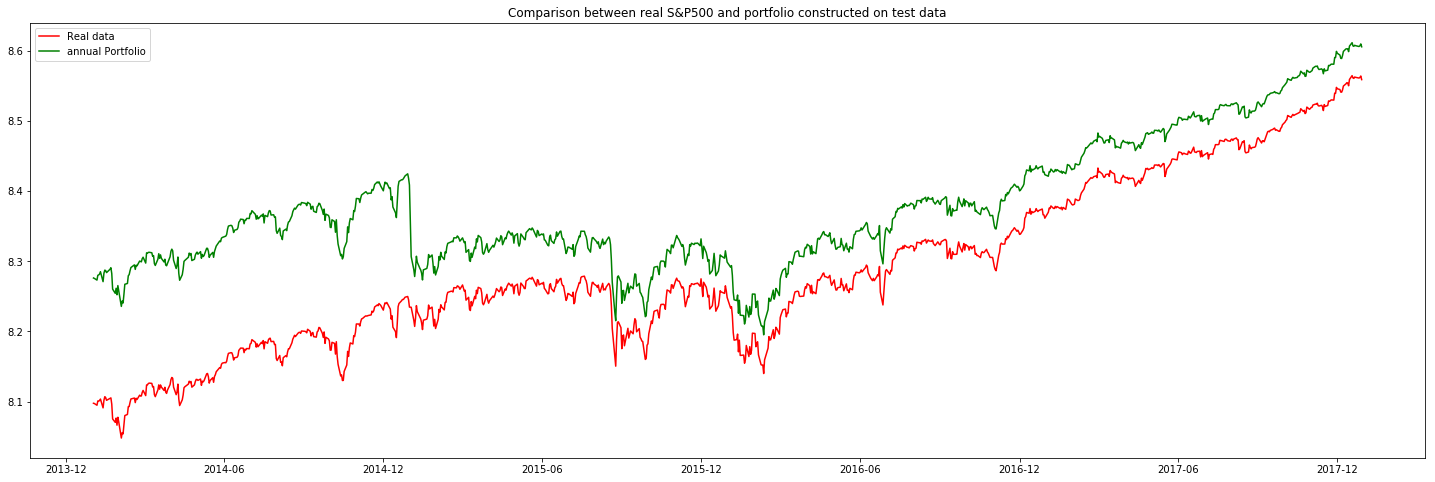

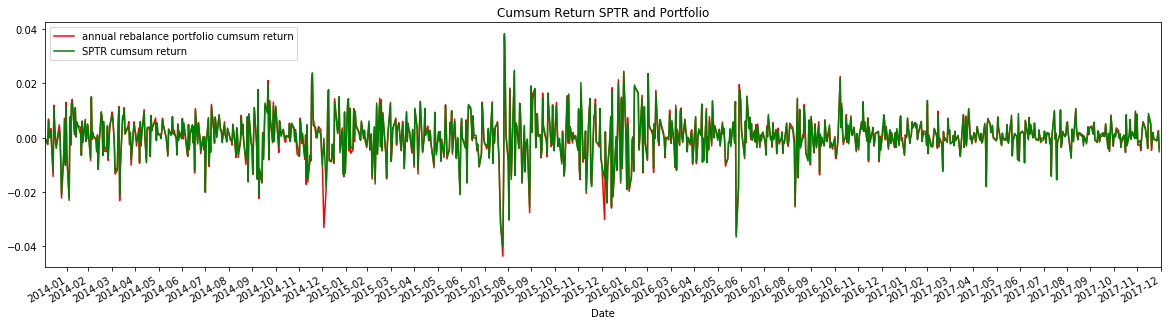

annual Tracking Error Variance is 0.00000199
Sum of square Tracking Error is 0.00201122
Information ratio of the annual portfolio is -0.056
Annual Correlation coefficient between portfolio and SPTR is 0.983913


In [27]:
SPTR_log_train = SPTR_log.loc["2008-01": "2013-12-31"].copy()

All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2013-12-31"].copy()

portfolio_test = pd.DataFrame(0,columns=['portf_forest','portfolio_test_intercept'] ,index=SPTR_log.loc['2014':'2017'].index)  # this is to store the test data from ETFs

LR_lasso_year = Lasso(alpha=0.000131, fit_intercept=True,normalize=None, positive=True)

LR_lasso_year.fit(All_ETFs_log_train,SPTR_log_train[['Adj Close']])

print('original coeff greater than 0 is ',np.sum(LR_lasso_year.coef_ > 0 ))
print('original coeff leass than 0 is ' ,np.sum(LR_lasso_year.coef_ < 0 ))
print('original coeff equal to 0 is ',np.sum(LR_lasso_year.coef_ == 0) )

index_of_etfs = LR_lasso_year.coef_ > 0 # these etfs are our portfolio etfs, we need those to build the portfolio,and to rebalance

All_ETFs_log_year = All_ETFs_log.loc[: , index_of_etfs] .copy()  # this contains all the etfs we used to build portfolio

coefficients= LR_lasso_year.coef_.copy()

nonzero_coeff  = coefficients[~(coefficients==0)].copy()

nonzero_coeff = nonzero_coeff/nonzero_coeff.sum()

portfolio_test.loc['2014','portf_forest'] = All_ETFs_log_year.dot(nonzero_coeff).loc['2014'].copy()

portfolio_test.loc['2014','portfolio_test_intercept'] = portfolio_test.loc['2014','portf_forest']+LR_lasso_year.intercept_

j = 1

for i in pd.date_range(start='2014', end='2017', freq='A'):
    
    Lasso_Model = Lasso(alpha=0.000000001 , fit_intercept=True,normalize=None,positive =True)
    
    All_ETFs_log_train = All_ETFs_log_year.loc['2008': i].copy()
   
    SPTR_log_train = SPTR_log.loc['2008': i].copy()
    
    Lasso_Model.fit(All_ETFs_log_train,SPTR_log_train[['Adj Close']])
    
    print('\n\nfor range in 2008 to'+str(i))
    
    print('number of coeff greater than 0 is ',np.sum(Lasso_Model.coef_ > 0 ))
   
    print('number of coeff leass than 0 is ' ,np.sum(Lasso_Model.coef_ < 0 ))
    
    print('number of coeff equal to 0 is ',np.sum(Lasso_Model.coef_ == 0) )
    
    Lasso_Model_residual = SPTR_log_train[['Adj Close']].values.flatten() - Lasso_Model.predict(All_ETFs_log_train)
   
    check_for_stationarity(Lasso_Model_residual.flatten(),cutoff=0.05)
   
    coefficients= Lasso_Model.coef_.copy()

    coefficients = coefficients/coefficients.sum()
    
    portfolio_test.loc[str(2014+j),'portf_forest'] = All_ETFs_log_year.dot(coefficients).loc[str(2014+j)].copy()
    
    portfolio_test.loc[str(2014+j),'portfolio_test_intercept'] = portfolio_test.loc[str(2014+j),'portf_forest']+Lasso_Model.intercept_

    
    j+=1
    
    print('%sth loop is good'%(j))

SPTR_log_test = SPTR_log.loc["2014-01-01": "2017-12-31"].copy()
plt.figure(figsize=(25,8))
plt.plot(SPTR_log_test.index,SPTR_log_test['Adj Close'], 'r-', label='Real data' )
plt.plot(SPTR_log_test.index,portfolio_test['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'g-', label='annual Portfolio' )
plt.legend(loc='upper left')
plt.title('Comparison between real S&P500 and portfolio constructed on test data')
plt.show()

SPTR_log_test['Daily_Return'] = SPTR_log_test['Adj Close'].diff()
SPTR_log_test['Daily_Return'][0] = 0
SPTR_log_test['Cumsum Daily_Return'] = SPTR_log_test['Daily_Return'].cumsum()

portfolio_test['Daily_Return'] = portfolio_test['portf_forest'].diff()
portfolio_test['Daily_Return'][0] = 0
portfolio_test['Cumsum Daily_Return'] = portfolio_test['Daily_Return'].cumsum()

portfolio_test['Daily_Return'].plot(kind='line',figsize=(20,5),label = 'annual rebalance portfolio cumsum return',style='r-')
SPTR_log_test['Daily_Return'].loc["2014-01-01": "2017-12-31"].plot(kind='line',figsize=(20,5),label = 'SPTR cumsum return',style='g-')
plt.legend(loc='upper left')
plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = 'M'))
plt.title('Cumsum Return SPTR and Portfolio')
plt.show()

Track_error_annual = portfolio_test['Daily_Return'] - SPTR_log_test['Daily_Return']

print('annual Tracking Error Variance is %.8f') %(np.var(Track_error_annual))

print('Sum of square Tracking Error is %.8f') %(np.sum(Track_error_annual**2))

print('Information ratio of the annual portfolio is %.3f')%(np.mean(Track_error_annual)/np.std(Track_error_annual))

print('Annual Correlation coefficient between portfolio and SPTR is %.6f')%(
    np.corrcoef(SPTR_log_test['Daily_Return'].values.flatten(),portfolio_test['Daily_Return'].values.flatten())[0,1])

In [28]:
print('year rebalance 2016 Correlation coefficient between portfolio and GSPC is %.6f')%(
    np.corrcoef(SPTR_log_test.loc['2016-01-05':'2016-12-30','Daily_Return'].values.flatten(),
                portfolio_test.loc['2016-01-05':'2016-12-30','Daily_Return'].values.flatten())[0,1])


year rebalance 2016 Correlation coefficient between portfolio and GSPC is 0.996080


In [29]:
for i in range(2014,2018):
    print 'for', i
    print('year rebalance Correlation coefficient between portfolio and GSPC is %.6f')%(
        np.corrcoef(SPTR_log_test.loc[str(i),'Daily_Return'].values.flatten(),
                    portfolio_test_nobalance.loc[str(i),'Daily_Return'].values.flatten())[0,1])


for 2014
year rebalance Correlation coefficient between portfolio and GSPC is 0.991406
for 2015
year rebalance Correlation coefficient between portfolio and GSPC is 0.994066
for 2016
year rebalance Correlation coefficient between portfolio and GSPC is 0.991236
for 2017
year rebalance Correlation coefficient between portfolio and GSPC is 0.978963


## SPTR semi-annual rebalance

('original coeff greater than 0 is ', 11)
('original coeff leass than 0 is ', 0)
('original coeff equal to 0 is ', 40)


for range in 2008 to2014-06-30 00:00:00
('number of coeff greater than 0 is ', 11)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 0)
p-value = 2.3324411227e-06 The series  is likely stationary.
1th loop is good


for range in 2008 to2014-12-31 00:00:00
('number of coeff greater than 0 is ', 10)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 1)
p-value = 5.848548407e-06 The series  is likely stationary.
2th loop is good


for range in 2008 to2015-06-30 00:00:00
('number of coeff greater than 0 is ', 10)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 1)
p-value = 3.73333025075e-06 The series  is likely stationary.
3th loop is good


for range in 2008 to2015-12-31 00:00:00
('number of coeff greater than 0 is ', 11)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is '

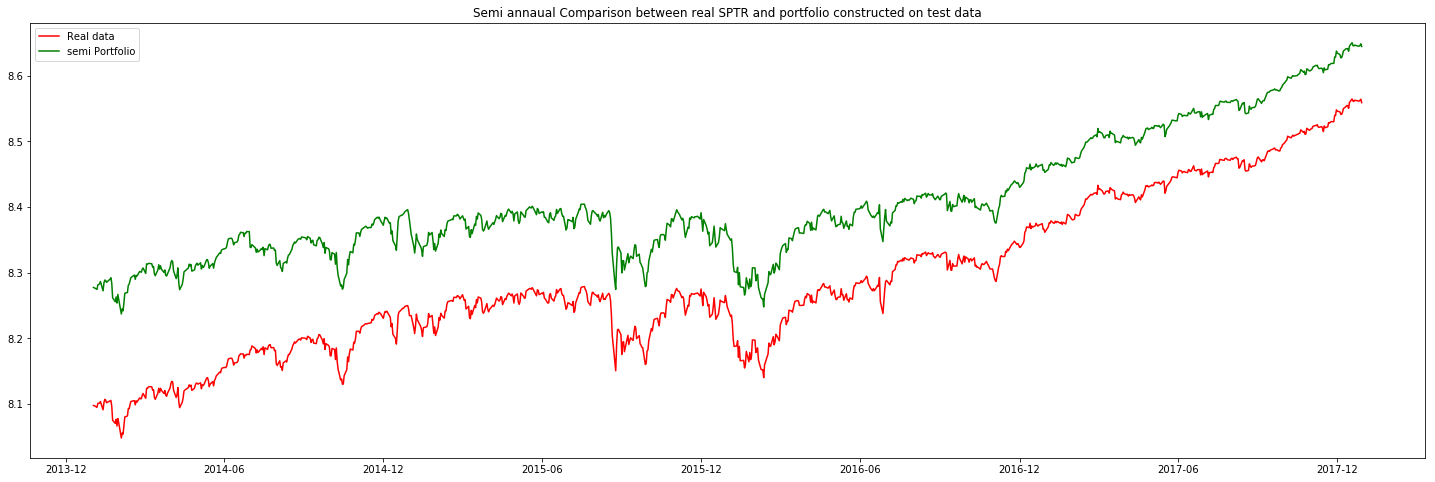

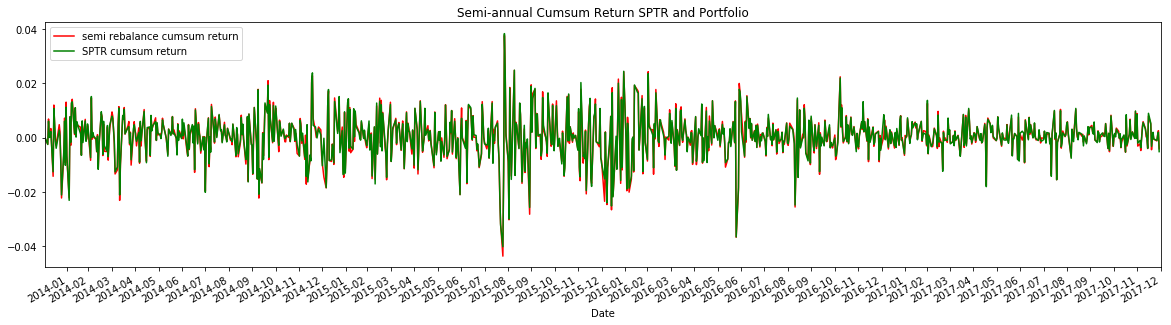

semi Tracking Error Variance is 0.00000112
Semi-annual information ratio of the annual portfolio is -0.055
Semi-annual  Correlation coefficient between portfolio and SPTR is 0.991035


In [30]:
SPTR_log_train = SPTR_log.loc["2008-01": "2013-12-31"].copy()

All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2013-12-31"].copy()

portfolio_test_semi = pd.DataFrame(0,columns=['portf_forest','portfolio_test_intercept'] ,index=SPTR_log.loc['2014':'2017'].index)  # this is to store the test data from ETFs

LR_lasso_semi = Lasso(alpha=0.000131, fit_intercept=True,normalize=None)

LR_lasso_semi.fit(All_ETFs_log_train,SPTR_log_train[['Adj Close']])

print('original coeff greater than 0 is ',np.sum(LR_lasso_semi.coef_ > 0 ))
print('original coeff leass than 0 is ' ,np.sum(LR_lasso_semi.coef_ < 0 ))
print('original coeff equal to 0 is ',np.sum(LR_lasso_semi.coef_ == 0) )

index_of_etfs = LR_lasso_semi.coef_ > 0 # these etfs are our portfolio etfs, we need those to build the portfolio,and to rebalance

All_ETFs_log_semi = All_ETFs_log.loc[: , index_of_etfs] .copy()  # this contains all the etfs we used to build portfolio

coefficients= LR_lasso_semi.coef_.copy()

nonzero_coeff  = coefficients[~(coefficients==0)].copy()

nonzero_coeff = nonzero_coeff/nonzero_coeff.sum()

portfolio_test_semi.loc['20140101':'20140630','portf_forest'] = All_ETFs_log_semi.dot(nonzero_coeff).loc['20140101':'20140630'].copy()

portfolio_test_semi.loc['20140101':'20140630','portfolio_test_intercept'] = portfolio_test_semi.loc['20140101':'20140630','portf_forest']+LR_lasso_semi.intercept_

j = 0

semi_dates_begin = pd.date_range(start='2014-07-01', end='2017-07-01', freq='6MS')

semi_dates_end = pd.date_range(start='2014-06-30', end='2017-12-31', freq='6M',closed='right')

for i in pd.date_range(start='2013-12-31', end='2017-06-30', freq='6M',closed='right'):
    
    Lasso_Model = Lasso(alpha=0.0001 , fit_intercept=True,normalize=None,positive =True)
    
    All_ETFs_log_train = All_ETFs_log_semi.loc['2008': i].copy()
   
    SPTR_log_train = SPTR_log.loc['2008': i].copy()
    
    Lasso_Model.fit(All_ETFs_log_train,SPTR_log_train[['Adj Close']])
    
    print('\n\nfor range in 2008 to'+str(i))
    
    print('number of coeff greater than 0 is ',np.sum(Lasso_Model.coef_ > 0 ))
   
    print('number of coeff leass than 0 is ' ,np.sum(Lasso_Model.coef_ < 0 ))
    
    print('number of coeff equal to 0 is ',np.sum(Lasso_Model.coef_ == 0) )
    
    Lasso_Model_residual = SPTR_log_train[['Adj Close']].values.flatten() - Lasso_Model.predict(All_ETFs_log_train)
   
    check_for_stationarity(Lasso_Model_residual.flatten(),cutoff=0.05)
   
    coefficients= Lasso_Model.coef_.copy()

    coefficients = coefficients/coefficients.sum()
    
    portfolio_test_semi.loc[semi_dates_begin[j]:semi_dates_end[j],'portf_forest'] = All_ETFs_log_semi.dot(coefficients).loc[semi_dates_begin[j]:semi_dates_end[j]].copy()
    
    portfolio_test_semi.loc[semi_dates_begin[j]:semi_dates_end[j],'portfolio_test_intercept'] = portfolio_test_semi.loc[semi_dates_begin[j]:semi_dates_end[j],'portf_forest']+Lasso_Model.intercept_

    
    j+=1
    
    print('%sth loop is good'%(j))

plt.figure(figsize=(25,8))
plt.plot(SPTR_log_test.index,SPTR_log_test['Adj Close'], 'r-', label='Real data' )
plt.plot(SPTR_log_test.index,portfolio_test_semi['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'g-', label='semi Portfolio' )
plt.legend(loc='upper left')
plt.title('Semi annaual Comparison between real SPTR and portfolio constructed on test data')
plt.show()
 
portfolio_test_semi['Daily_Return'] = portfolio_test_semi['portf_forest'].diff()
portfolio_test_semi['Daily_Return'][0] = 0
portfolio_test_semi['Cumsum Daily_Return'] = portfolio_test_semi['Daily_Return'].cumsum()

portfolio_test_semi['Daily_Return'].plot(kind='line',figsize=(20,5),label = 'semi rebalance cumsum return',style='r-')
SPTR_log_test['Daily_Return'].loc["2014-01-01": "2017-12-31"].plot(kind='line',figsize=(20,5),label = 'SPTR cumsum return',style='g-')
plt.legend(loc='upper left')
plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = 'M'))
plt.title('Semi-annual Cumsum Return SPTR and Portfolio')
plt.show()

Track_error_semi = portfolio_test_semi['Daily_Return'] - SPTR_log_test['Daily_Return']

print('semi Tracking Error Variance is %.8f') %(np.var(Track_error_semi))

np.sum(Track_error_semi**2)

print('Semi-annual information ratio of the annual portfolio is %.3f')%(np.mean(Track_error_semi)/np.std(Track_error_semi))

print('Semi-annual  Correlation coefficient between portfolio and SPTR is %.6f')%(
    np.corrcoef(SPTR_log_test['Daily_Return'].values.flatten(),portfolio_test_semi['Daily_Return'].values.flatten())[0,1])

## rebalance quarterly

('original coeff greater than 0 is ', 8)
('original coeff leass than 0 is ', 0)
('original coeff equal to 0 is ', 43)


for range in 2008 to2014-03-31 00:00:00
('number of coeff greater than 0 is ', 7)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 1)
p-value = 0.0003960016688 The series  is likely stationary.
2th loop is good


for range in 2008 to2014-06-30 00:00:00
('number of coeff greater than 0 is ', 7)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 1)
p-value = 0.0012270049485 The series  is likely stationary.
3th loop is good


for range in 2008 to2014-09-30 00:00:00
('number of coeff greater than 0 is ', 7)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 1)
p-value = 0.0100514250454 The series  is likely stationary.
4th loop is good


for range in 2008 to2014-12-31 00:00:00
('number of coeff greater than 0 is ', 7)
('number of coeff leass than 0 is ', 0)
('number of coeff equal to 0 is ', 1)
p-v

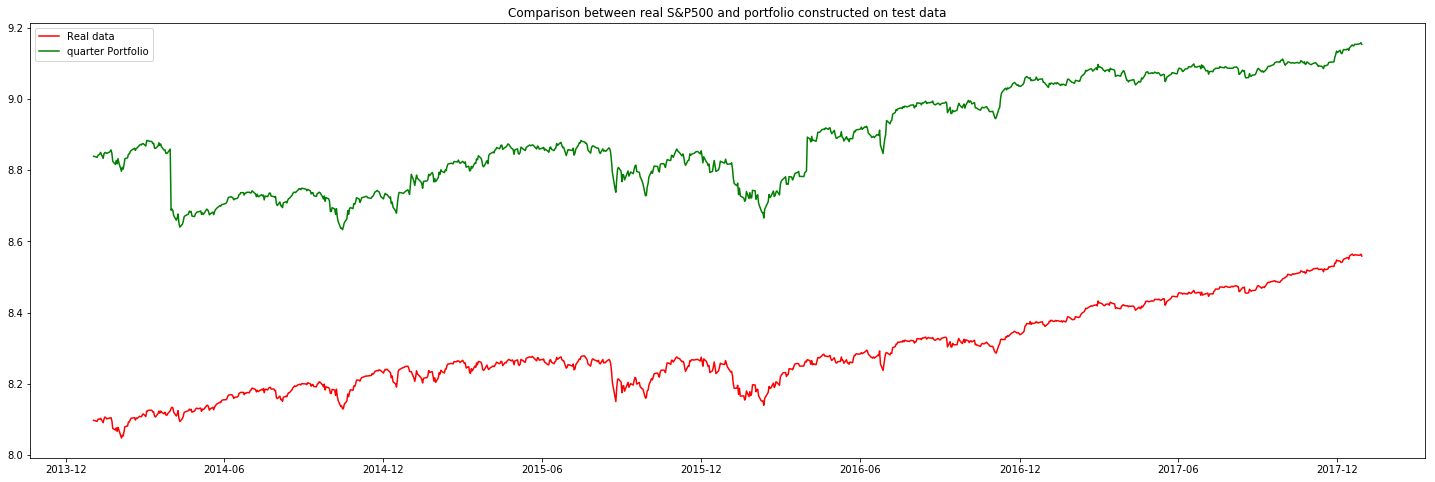

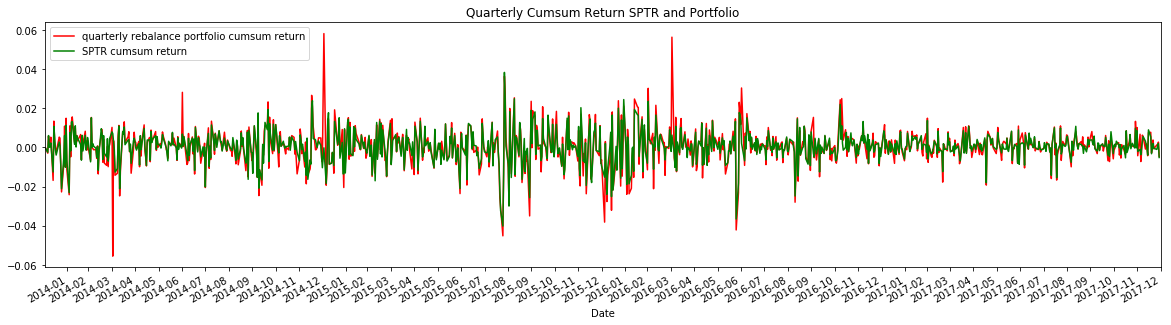

Quarter Tracking Error Variance is 0.00001886
Quarter information ratio of the portfolio is 0.003
Quarterly  Correlation coefficient between portfolio and SPTR is 0.890383


In [31]:
SPTR_log_train = SPTR_log.loc["2008-01": "2013-12-31"].copy()

All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2013-12-31"].copy()

portfolio_test_quarter = pd.DataFrame(0,columns=['portf_forest','portfolio_test_intercept'] ,index=SPTR_log.loc['2014':'2017'].index)  # this is to store the test data from ETFs

LR_lasso_quarter = Lasso(alpha=0.000891, fit_intercept=True,normalize=None)

LR_lasso_quarter.fit(All_ETFs_log_train,SPTR_log_train[['Adj Close']])

print('original coeff greater than 0 is ',np.sum(LR_lasso_quarter.coef_ > 0 ))
print('original coeff leass than 0 is ' ,np.sum(LR_lasso_quarter.coef_ < 0 ))
print('original coeff equal to 0 is ',np.sum(LR_lasso_quarter.coef_ == 0) )

index_of_etfs = LR_lasso_quarter.coef_ > 0 # these etfs are our portfolio etfs, we need those to build the portfolio,and to rebalance

All_ETFs_log_quarter = All_ETFs_log.loc[: , index_of_etfs] .copy()  # this contains all the etfs we used to build portfolio

coefficients= LR_lasso_quarter.coef_.copy()

nonzero_coeff  = coefficients[~(coefficients==0)].copy()

nonzero_coeff = nonzero_coeff/nonzero_coeff.sum()

portfolio_test_quarter.loc['2014Q1','portf_forest'] = All_ETFs_log_quarter.dot(nonzero_coeff).loc['2014Q1'].copy()

portfolio_test_quarter.loc['2014Q1','portfolio_test_intercept'] = portfolio_test_quarter.loc['2014Q1','portf_forest']+LR_lasso_quarter.intercept_

quarter_dates = [str(i)+j for i in range(2014,2018) for j in ['Q1','Q2','Q3','Q4']]
 
j = 1


for i in pd.date_range(start='2014Q1', end='2017Q4', freq='Q'):   
    
    Lasso_Model = Lasso(alpha=0.0001 , fit_intercept=True,normalize=None,positive =True)
    
    All_ETFs_log_train = All_ETFs_log_quarter.loc['2008': i].copy()
   
    SPTR_log_train = SPTR_log.loc['2008': i].copy()
    
    Lasso_Model.fit(All_ETFs_log_train,SPTR_log_train[['Adj Close']])
    
    print('\n\nfor range in 2008 to'+str(i))
    
    print('number of coeff greater than 0 is ',np.sum(Lasso_Model.coef_ > 0 ))
   
    print('number of coeff leass than 0 is ' ,np.sum(Lasso_Model.coef_ < 0 ))
    
    print('number of coeff equal to 0 is ',np.sum(Lasso_Model.coef_ == 0) )
    
    Lasso_Model_residual = SPTR_log_train[['Adj Close']].values.flatten() - Lasso_Model.predict(All_ETFs_log_train)
   
    check_for_stationarity(Lasso_Model_residual.flatten(),cutoff=0.05)
   
    coefficients= Lasso_Model.coef_.copy()

    coefficients = coefficients/coefficients.sum()
    
    portfolio_test_quarter.loc[quarter_dates[j],'portf_forest'] = All_ETFs_log_quarter.dot(coefficients).loc[quarter_dates[j]].copy()
    
    portfolio_test_quarter.loc[quarter_dates[j],'portfolio_test_intercept'] = portfolio_test_quarter.loc[quarter_dates[j],'portf_forest']+Lasso_Model.intercept_

    j+=1
    
    print('%sth loop is good'%(j))
 


plt.figure(figsize=(25,8))
plt.plot(SPTR_log_test.index,SPTR_log_test['Adj Close'], 'r-', label='Real data' )
plt.plot(SPTR_log_test.index,portfolio_test_quarter['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'g-', label='quarter Portfolio' )
plt.legend(loc='upper left')
plt.title('Comparison between real S&P500 and portfolio constructed on test data')
plt.show()

portfolio_test_quarter['Daily_Return'] = portfolio_test_quarter['portf_forest'].diff()
portfolio_test_quarter['Daily_Return'][0] = 0
portfolio_test_quarter['Cumsum Daily_Return'] = portfolio_test_quarter['Daily_Return'].cumsum()

portfolio_test_quarter['Daily_Return'].plot(kind='line',figsize=(20,5),label = 'quarterly rebalance portfolio cumsum return',style='r-')
SPTR_log_test['Daily_Return'].loc["2014-01-01": "2017-12-31"].plot(kind='line',figsize=(20,5),label = 'SPTR cumsum return',style='g-')
plt.legend(loc='upper left')
plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = 'M'))
plt.title('Quarterly Cumsum Return SPTR and Portfolio')
plt.show()

Track_error_quarter = portfolio_test_quarter['Daily_Return'] - SPTR_log_test['Daily_Return']

print('Quarter Tracking Error Variance is %.8f') %(np.var(Track_error_quarter))

np.sum(Track_error_quarter**2)

print('Quarter information ratio of the portfolio is %.3f')%(np.mean(Track_error_quarter)/np.std(Track_error_quarter))

print('Quarterly  Correlation coefficient between portfolio and SPTR is %.6f')%(
    np.corrcoef(SPTR_log_test['Daily_Return'].values.flatten(),portfolio_test_quarter['Daily_Return'].values.flatten())[0,1])


In [22]:
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = ADF(X)[1]
    if pvalue < cutoff:
        print 'p-value = ' + str(pvalue) + ' The series '  +' is likely stationary.'
        #return True
    else:
        print 'p-value = ' + str(pvalue) + ' The series '+' is likely non-stationary.'
        #return False

In [23]:
def check_for_stationarity_no_print(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = ADF(X)[1]
    if pvalue < cutoff:
        #print 'p-value = ' + str(pvalue) + ' The series '  +' is likely stationary.'
        return True
    else:
        #print 'p-value = ' + str(pvalue) + ' The series '+' is likely non-stationary.'
        return False